# Regression Plots

This Jupyter Notebook is part of the time travel distance project. In this notebook we visualise the results of the linear regression models.

## Import

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tueplots import bundles

In [2]:
# read model fits
fit_combi_abs = sm.load("models/fit_combi_abs.pickle")
fit_horiz = sm.load("models/fit_horiz.pickle")
fit_combi_extended = sm.load("models/fit_combi_extended.pickle")

# read dataset
df = pd.read_csv('data/combined_data.csv')

## Set global plot settings

In [3]:
# use Neurips adjustments
plt.rcParams.update(bundles.neurips2021(usetex=False))

# use ggplot style
plt.style.use('ggplot')

# pick colors
colors_points = {'driving': "#1f77b4", 'walking': "#9467bd", 'bicycling': "#ff7f0e", }
colors_fit = {'driving': "#3977AF",  'walking': "#ac4ed4", 'bicycling': "#EF8536",}

## Global regression plot function

In [4]:
def regression_plot(x, key, model, model_name, title, xlabel, show_CI = False, savefig=True, datakey=None):
    
    #if not savefig: 
    plt.figure(figsize=(5, 3.5))
        
    if datakey == None:
        datakey = key

    # plot datasets per group
    groups = df.groupby('mode')
    for name, group in groups:
        plt.plot(group[datakey], group.duration/60, marker='o', linestyle='', ms=1, label='_nolegend_', color = colors_points[name], alpha=0.5)

    # create endogen dataframe
    X = pd.DataFrame({'x': x, 
                      'distance_horizontal': 0, 
                      'distance_vertical_abs': 0, 
                      'distance_vertical_pos': 0,
                      'distance_vertical_neg': 0,
                      'isBicycling': 0 , 
                      'isWalking': 0})
        
    # insert x data
    X[key] = x
    
    # plot regression per group
    for name, group in groups: 

        # exogen dataframe
        if name == 'bicycling':
            X.isBicycling = 1
                
        elif name == 'walking':
            X.isBicycling = 1
            X.isWalking = 1
            
        else:
            X.isBicycling = 0
            X.isWalking = 0  
            
        # get predrictions
        predictions = np.abs(model.get_prediction(X).summary_frame(alpha=0.05)/60)

        # regression line
        plt.plot(x, predictions['mean'], lw=2, label=name+' fit', color=colors_fit[name])

        if show_CI:
            plt.plot(x, predictions['mean_ci_lower'], lw=0.5, label=name+' fit', color=colors_fit[name], linestyle='dashed')
            plt.plot(x, predictions['mean_ci_upper'], lw=0.5, label=name+' fit', color=colors_fit[name], linestyle='dashed')

    # design
    plt.xlim((min(x), max(x)))
    plt.title(title)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Travel time [minutes]', fontsize=16)
    #plt.legend(loc='upper center', prop={'size': 12})
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          fancybox=True, shadow=False, ncol=5, prop={'size': 10})
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='minor', labelsize=8)

    if savefig:
        plt.savefig('plots/' + model_name + '/' + datakey + '_estimates.png', dpi=300);
        

## Only horizontal model

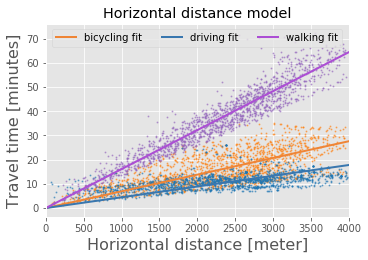

In [5]:
regression_plot(x = np.linspace(0, 4000),
                key = 'distance_horizontal',
                model = fit_horiz, 
                model_name = 'horizontal_model',
                title = 'Horizontal distance model',
                xlabel = 'Horizontal distance [meter]')

## Combined model

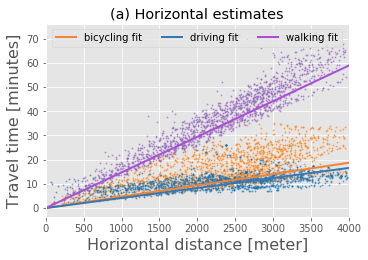

In [6]:
regression_plot(x = np.linspace(0, 4000),
                key = 'distance_horizontal',
                model = fit_combi_abs, 
                model_name = 'combined_model',
                title = '(a) Horizontal estimates',
                xlabel = 'Horizontal distance [meter]')

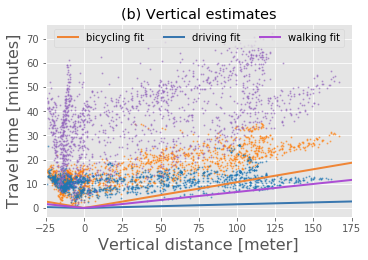

In [7]:
regression_plot(x = np.linspace(-25, 175),
                key = 'distance_vertical_abs',
                datakey = 'distance_vertical',
                model = fit_combi_abs, 
                model_name = 'combined_model',
                title = '(b) Vertical estimates',
                xlabel = 'Vertical distance [meter]')

## 3D Plot

In [ ]:
# define grid of points
x = np.arange(-25, 175, 5)
y = np.arange(0, 4000, 5)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()

# calculate regression planes
z_driving = np.abs(xv* fit_combi_abs.params['distance_vertical_abs']) + yv * fit_combi_abs.params['distance_horizontal']
z_bicycle = z_driving + np.abs(xv * fit_combi_abs.params['distance_vertical_abs:isBicycling[T.True]']) + yv * fit_combi_abs.params['distance_horizontal:isBicycling[T.True]']    
z_walking = z_bicycle + np.abs(xv* fit_combi_abs.params['distance_vertical_abs:isWalking[T.True]']) + yv * fit_combi_abs.params['distance_horizontal:isWalking[T.True]']    

# reshape
z_bicycle = z_bicycle.reshape((y.shape[0], x.shape[0]))/60
z_driving = z_driving.reshape((y.shape[0], x.shape[0]))/60
z_walking = z_walking.reshape((y.shape[0], x.shape[0]))/60

In [ ]:
# plot
df['duration_min'] = df.duration/60
fig = px.scatter_3d(df, x='distance_vertical', y='distance_horizontal', z='duration_min',
              color='mode', color_discrete_sequence=list(colors_points.values()), width=1000, height=800, 
                   labels={
                     "distance_horizontal": "Horizontal distance [meter]",
                     "distance_vertical": "Vertical distance [meter]",
                     "duration_min": "Duration [minutes]"
                 })

# style
fig.update_traces(marker_size = 2)
c1 = [[0, colors_fit['driving']], [1, colors_fit['driving']]]
c2 = [[0, colors_fit['bicycling']], [1, colors_fit['bicycling']]]
c3 = [[0, colors_fit['walking']], [1, colors_fit['walking']]]

# add regression planes
fig.add_trace(go.Surface(x=x, y=y, z=z_driving, showscale=False, colorscale=c1))
fig.add_trace(go.Surface(x=x, y=y, z=z_bicycle, showscale=False, colorscale=c2))
fig.add_trace(go.Surface(x=x, y=y, z=z_walking, showscale=False, colorscale=c3))

fig.update_layout(title_text='3D Regression plot for simple combined model', 
                  title_x=0.5)

fig.show()

# Additional exploratory analysis - Extended combined model

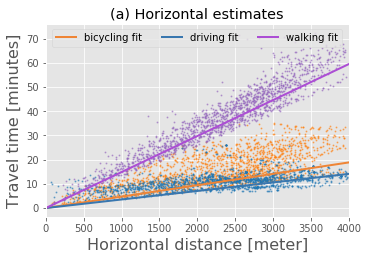

In [8]:
regression_plot(x = np.linspace(0, 4000),
                key = 'distance_horizontal',
                model = fit_combi_extended, 
                model_name = 'extended_combined_model',
                title = '(a) Horizontal estimates',
                xlabel = 'Horizontal distance [meter]')

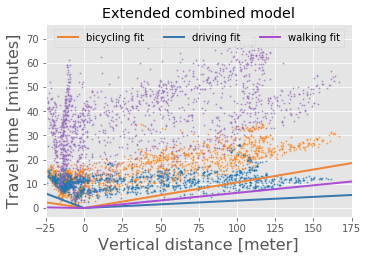

In [9]:
savefig = True
if savefig: 
    plt.figure(figsize=(5, 3.5))

# plot datasets per group
groups = df.groupby('mode')
for name, group in groups:
    plt.plot(group.distance_vertical, group.duration/60, marker='o', linestyle='', ms=1, label='_nolegend_', color = colors_points[name], alpha=0.5)

# plot regression per group
for name, group in groups:
    
    # grid
    x_pos = np.linspace(0, 175)
    x_neg = np.abs(np.linspace(-25, 0))
    x = np.concatenate((-1*x_neg, x_pos))
    
    if name == 'driving':
        y_neg = x_neg * fit_combi_extended.params['distance_vertical_neg']
        y_pos = x_pos * fit_combi_extended.params['distance_vertical_pos']

    elif name == 'bicycling':
        y_neg = x_neg * fit_combi_extended.params['distance_vertical_neg'] + x_neg * fit_combi_extended.params['distance_vertical_neg:isBicycling[T.True]']   
        y_pos = x_pos * fit_combi_extended.params['distance_vertical_pos'] + x_pos * fit_combi_extended.params['distance_vertical_pos:isBicycling[T.True]']   

    else:
        y_neg = x_neg * fit_combi_extended.params['distance_vertical_neg'] + x_neg * fit_combi_extended.params['distance_vertical_neg:isBicycling[T.True]'] + x_neg * fit_combi_extended.params['distance_vertical_neg:isWalking[T.True]']
        y_pos = x_pos * fit_combi_extended.params['distance_vertical_pos'] + x_pos * fit_combi_extended.params['distance_vertical_pos:isBicycling[T.True]'] + x_pos * fit_combi_extended.params['distance_vertical_pos:isWalking[T.True]']
    
    
    y_hat = np.concatenate((y_neg, y_pos)) 
    plt.plot(x, y_hat/60, lw=2, label=name+' fit', color=colors_fit[name])
    
    
# design
plt.xlim((min(x), max(x)))
plt.title('Extended combined model')
plt.xlabel('Vertical distance [meter]', fontsize=16)
plt.ylabel('Travel time [minutes]', fontsize=16)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
      fancybox=True, shadow=False, ncol=5, prop={'size': 10})
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)

if savefig:
    plt.savefig('plots/extended_combined_model/vertical_estimates.png', dpi=300);
    

## 3D Plot

In [ ]:
# define grid of points
x_neg = np.abs(np.linspace(-25, 0))
x_pos = np.linspace(0, 175)
x = np.concatenate((-x_neg, x_pos))
y = np.arange(0, 4000)

# negative meshgrid
xv_neg, yv_neg = np.meshgrid(x_neg, y)
xv_neg = xv_neg.flatten()
yv_neg = yv_neg.flatten()

#positive mehsgrid
xv_pos, yv_pos = np.meshgrid(x_pos, y)
xv_pos = xv_pos.flatten()
yv_pos = yv_pos.flatten()

# calculate negative regression planes
z_driving_neg = xv_neg * fit_combi_extended.params['distance_vertical_neg'] + yv_neg * fit_combi_extended.params['distance_horizontal']
z_bicycle_neg = z_driving_neg + xv_neg * fit_combi_extended.params['distance_vertical_neg:isBicycling[T.True]'] + yv_neg * fit_combi_extended.params['distance_horizontal:isBicycling[T.True]']    
z_walking_neg = z_bicycle_neg + xv_neg * fit_combi_extended.params['distance_vertical_neg:isWalking[T.True]'] + yv_neg * fit_combi_extended.params['distance_horizontal:isWalking[T.True]']    

# calculate positive regression planes
z_driving_pos = xv_pos * fit_combi_extended.params['distance_vertical_pos'] + yv_pos * fit_combi_extended.params['distance_horizontal']
z_bicycle_pos = z_driving_pos + xv_pos * fit_combi_extended.params['distance_vertical_pos:isBicycling[T.True]'] + yv_pos * fit_combi_extended.params['distance_horizontal:isBicycling[T.True]']    
z_walking_pos = z_bicycle_pos + xv_pos * fit_combi_extended.params['distance_vertical_pos:isWalking[T.True]'] + yv_pos * fit_combi_extended.params['distance_horizontal:isWalking[T.True]']    


# reshape
z_bicycle_neg = z_bicycle_neg.reshape((y.shape[0], x_neg.shape[0]))/60
z_driving_neg = z_driving_neg.reshape((y.shape[0], x_neg.shape[0]))/60
z_walking_neg = z_walking_neg.reshape((y.shape[0], x_neg.shape[0]))/60

z_bicycle_pos = z_bicycle_pos.reshape((y.shape[0], x_pos.shape[0]))/60
z_driving_pos = z_driving_pos.reshape((y.shape[0], x_pos.shape[0]))/60
z_walking_pos = z_walking_pos.reshape((y.shape[0], x_pos.shape[0]))/60


In [ ]:
# plot
df['duration_min'] = df.duration/60
fig = px.scatter_3d(df, x='distance_vertical', y='distance_horizontal', z='duration_min',
              color='mode', color_discrete_sequence=list(colors_points.values()), width=1000, height=800, 
                   labels={
                     "distance_horizontal": "Horizontal distance [meter]",
                     "distance_vertical": "Vertical distance [meter]",
                     "duration_min": "Duration [minutes]"
                 })

# style
fig.update_traces(marker_size = 2)
c1 = [[0, colors_fit['driving']], [1, colors_fit['driving']]]
c2 = [[0, colors_fit['bicycling']], [1, colors_fit['bicycling']]]
c3 = [[0, colors_fit['walking']], [1, colors_fit['walking']]]

# add regression planes
fig.add_trace(go.Surface(x=x_pos, y=y, z=z_driving_pos, showscale=False, colorscale=c1))
fig.add_trace(go.Surface(x=x_pos, y=y, z=z_bicycle_pos, showscale=False, colorscale=c2))
fig.add_trace(go.Surface(x=x_pos, y=y, z=z_walking_pos, showscale=False, colorscale=c3))

fig.add_trace(go.Surface(x=-x_neg, y=y, z=z_driving_neg, showscale=False, colorscale=c1))
fig.add_trace(go.Surface(x=-x_neg, y=y, z=z_bicycle_neg, showscale=False, colorscale=c2))
fig.add_trace(go.Surface(x=-x_neg, y=y, z=z_walking_neg, showscale=False, colorscale=c3))

fig.update_layout(title_text='3D Regression plot for extended combined model', 
                  title_x=0.5)

fig.show()